In [1]:
import json
import glob

import numpy as np
import pandas as pd

from qiskit import transpile
from qiskit import execute, QuantumRegister, ClassicalRegister, Aer
from qiskit.providers.fake_provider import FakeLima
from qiskit.primitives import Estimator
from qiskit.circuit.random import random_circuit

import torch
from torch.optim import Adam
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.nn.functional import dropout

from torch_geometric.nn import GCNConv, global_mean_pool, Linear, ChebConv, SAGEConv
from torch_geometric.data import Data
from torch_geometric.loader import DataLoader

from tqdm.notebook import tqdm_notebook
import matplotlib.pyplot as plt
import seaborn as sns

from blackwater.data.loaders.exp_val import CircuitGraphExpValMitigationDataset
from blackwater.data.generators.exp_val import exp_value_generator
from blackwater.data.utils import generate_random_pauli_sum_op
from blackwater.library.ngem.estimator import ngem

from qiskit.quantum_info import random_clifford

import random
from qiskit.circuit.library import HGate, SdgGate
from qiskit.circuit import ClassicalRegister

from blackwater.data.utils import (
    generate_random_pauli_sum_op,
    create_estimator_meas_data,
    circuit_to_graph_data_json,
    get_backend_properties_v1,
    encode_pauli_sum_op,
    create_meas_data_from_estimators
)
from blackwater.data.generators.exp_val import ExpValueEntry
from blackwater.metrics.improvement_factor import improvement_factor, Trial, Problem

from qiskit_aer import AerSimulator, QasmSimulator
from qiskit.providers.fake_provider import FakeMontreal, FakeLima

from torch_geometric.nn import (
    GCNConv,
    TransformerConv,
    GATv2Conv,
    global_mean_pool,
    Linear,
    ChebConv,
    SAGEConv,
    ASAPooling,
    dense_diff_pool,
    avg_pool_neighbor_x
)
from torch_geometric.data import Data
from torch_geometric.loader import DataLoader
from torch_geometric.utils import to_dense_adj, to_dense_batch

from qiskit import QuantumCircuit
from qiskit.circuit.library import U3Gate, CZGate, PhaseGate, CXGate
from mbd_utils import construct_random_clifford, cal_z_exp, calc_imbalance, cal_all_z_exp, construct_mbl_circuit, generate_disorder
from gnn import ExpValCircuitGraphModel

In [2]:
backend = FakeMontreal()
properties = get_backend_properties_v1(backend)

## Local
backend_ideal = QasmSimulator() # Noiseless
backend_noisy = AerSimulator.from_backend(backend) # Noisy

run_config_ideal = {'shots': 10000, 'backend': backend_ideal, 'name': 'ideal'}
run_config_noisy = {'shots': 10000, 'backend': backend_noisy, 'name': 'noisy'}

# Training

In [3]:
train_paths = [
    # './data/tiling/train/step6_q0-q3_total8_seed0.json',
    # './data/tiling/train/step6_q2-q5_total8_seed1.json',
    # './data/tiling/train/step6_q4-q7_total8_seed2.json',
    # './data/tiling/train/step6_q1-q4_total8_seed3.json',
    # './data/tiling/train/step6_q3-q6_total8_seed4.json'
    # f'./data/tiling/train/step6_q0-q7_total8_seed{i}.json' for i in range(3)
    './data/circ_cut/train/step10_cut_34_seed0.json',
    './data/circ_cut/train/step10_cut_01_45_seed1.json',
    './data/circ_cut/train/step10_cut_12_56_seed2.json',
    './data/circ_cut/train/step10_cut_23_67_seed3.json',
]

val_paths = [
     # 'data/tiling/val/step6_q0-q7_total8_seed0.json'
    'data/tiling/val/step10_q0-q7_total8_seed0.json'
]

In [4]:
BATCH_SIZE = 32

train_loader = DataLoader(
    CircuitGraphExpValMitigationDataset(
        train_paths,
    ),
    batch_size=BATCH_SIZE,
    shuffle=True
)

val_loader = DataLoader(
    CircuitGraphExpValMitigationDataset(
        val_paths,
    ),
    batch_size=BATCH_SIZE,
    shuffle=False
)

for data in train_loader:
    print(data)
    break

DataBatch(x=[13759, 22], edge_index=[2, 28960], edge_attr=[15201, 3], y=[32, 1, 8], observable=[32, 0], circuit_depth=[32, 1], noisy_0=[32, 1, 8], batch=[13759], ptr=[33])


In [5]:
model = ExpValCircuitGraphModel(
    num_node_features=22,
    hidden_channels=15,
    exp_value_size=8
)
criterion = torch.nn.MSELoss()

optimizer = Adam(model.parameters(), lr=0.001)
scheduler = ReduceLROnPlateau(optimizer,
                              'min',
                              factor=0.1,
                              patience=15,
                              verbose=True,
                              min_lr=0.00001)

In [6]:
print(sum(p.numel() for p in model.parameters() if p.requires_grad))
print(len(train_loader) * BATCH_SIZE, len(val_loader) * BATCH_SIZE)

13769
4000 1024


In [7]:
min_valid_loss = np.inf

train_losses = []
val_losses = []

N_EPOCHS = 100

progress = tqdm_notebook(range(N_EPOCHS), desc='Model training', leave=True)
for epoch in progress:
    train_loss = 0.0
    model.train()
    for i, data in enumerate(train_loader):
        optimizer.zero_grad()

        out = model(
            data.noisy_0,
            data.observable,
            data.circuit_depth,
            data.x,
            data.edge_index,
            data.batch
        )
        loss = criterion(out, torch.squeeze(data.y, 1))

        train_loss += loss.item()

        loss.backward()
        optimizer.step()

    valid_loss = 0.0
    model.eval()
    for i, data in enumerate(val_loader):
        out = model(
            data.noisy_0,
            data.observable,
            data.circuit_depth,
            data.x,
            data.edge_index,
            data.batch)
        loss = criterion(out, torch.squeeze(data.y, 1))

        valid_loss += loss.item()

    scheduler.step(valid_loss)

    if epoch >= 1:
        train_losses.append(train_loss / len(train_loader))
        val_losses.append(valid_loss / len(val_loader))

        progress.set_description(f"{round(train_losses[-1], 5)}, {round(val_losses[-1], 5)}")
        progress.refresh()

Model training:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch 00043: reducing learning rate of group 0 to 1.0000e-04.
Epoch 00072: reducing learning rate of group 0 to 1.0000e-05.


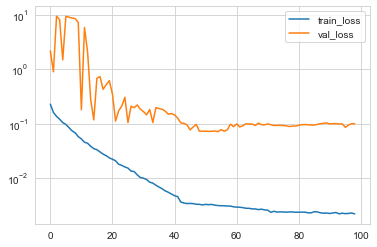

In [10]:
plt.style.use({'figure.facecolor':'white'})

plt.plot(train_losses, label="train_loss")
plt.plot(val_losses, label="val_loss")
plt.yscale('log')

plt.legend()
plt.show()

In [11]:
model_path = './model/tiling/circ_cut.pth'

In [12]:
torch.save(model.state_dict(), model_path)

In [13]:
import pickle
to_save = {'train_losses': train_losses, 'val_losses': val_losses}
with open('.' + model_path.split('.')[1] + '.pk', 'wb') as handle:
    pickle.dump(to_save, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [14]:
model = ExpValCircuitGraphModel(
    num_node_features=22,
    hidden_channels=15,
    exp_value_size=8
)
model.load_state_dict(torch.load(model_path))
model.eval()

ExpValCircuitGraphModel(
  (transformer1): TransformerConv(22, 15, heads=3)
  (pooling1): ASAPooling(45, ratio=0.5)
  (transformer2): TransformerConv(45, 15, heads=2)
  (pooling2): ASAPooling(30, ratio=0.5)
  (body_seq): Sequential(
    (0): Linear(39, 15, bias=True)
    (1): Dropout(p=0.2, inplace=False)
    (2): Linear(15, 8, bias=True)
  )
)

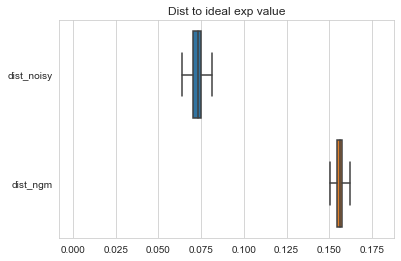

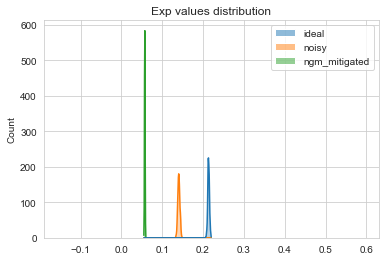

In [16]:
plt.style.use({'figure.facecolor':'white'})

distances = []
for i, data in enumerate(val_loader):
    out = model(data.noisy_0, data.observable, data.circuit_depth, data.x, data.edge_index, data.batch)

    for ideal, noisy, ngm_mitigated in zip(
        data.y.tolist(),
        data.noisy_0.tolist(),
        out.tolist()
    ):
        ideal = np.mean(ideal)
        noisy = np.mean(noisy)
        ngm_mitigated = np.mean(ngm_mitigated)
        distances.append({
            "ideal": ideal,
            "noisy": noisy,
            "ngm_mitigated": ngm_mitigated,
            "dist_noisy": np.abs(ideal - noisy),
            "dist_ngm": np.abs(ideal - ngm_mitigated),
        })

df = pd.DataFrame(distances)
sns.boxplot(data=df[["dist_noisy", "dist_ngm"]], orient="h", showfliers = False)
plt.xlim([-0.008, 0.188])
plt.title("Dist to ideal exp value")
plt.show()

sns.histplot([df['ideal'], df['noisy'], df["ngm_mitigated"]], kde=True, bins=140)
plt.xlim([-0.19, 0.63])
plt.title("Exp values distribution")
plt.show()